In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import os
# Make sure we're in the right directory
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

from os.path import join
from pathlib import Path
from typing import Optional, Union, List, Sequence
import pytorch_lightning as pl
import numpy as np
import xarray as xr
import torch
import torch.nn as nn
from torch import Tensor
from matplotlib import pyplot as plt
from src.utilities.wandb_api import reload_checkpoint_from_wandb
from src.interface import get_predictions
import properscoring as ps
import pandas as pd
import seaborn as sns
import datetime

Validate CRPS (continuous ranked probability score)

Low when observation and forecast distributions are the same

In [3]:
observations = np.random.RandomState(0).normal(2, 0.1, 1000)
ensemble = np.random.RandomState(0).normal(2, 0.1, (1000,100))
ps.crps_ensemble(observations, ensemble).mean()

0.0563791387637056

High when they are different

In [5]:
observations = np.random.RandomState(0).normal(2, 0.1, 1000)
ensemble = np.random.RandomState(0).normal(10, 0.1, (1000,100))
ps.crps_ensemble(observations, ensemble).mean()

7.949028852402396

In [3]:
# data_dir = Path("/global/cfs/cdirs/m3504/oisstv2-daily")
data_dir = Path("/Users/hailey/repos/convex-diffusion/data/processed-60x60-boxes-pixelwise-stats/")
wandb_id = '3kkx899f'

In [5]:
def reload_module(wandb_id, data_dir):
    return reload_checkpoint_from_wandb(wandb_id,
                                            entity='convex-diffusion',
                                            override_key_value=[f'datamodule.data_dir={str(data_dir)}'])

In [195]:
%%time
module = reload_module(wandb_id, data_dir)

CPU times: user 6.01 s, sys: 1.28 s, total: 7.29 s
Wall time: 23.6 s


In [196]:
module

{'model': UnetConvNext(
   (criterion): MSELoss()
   (val_metrics): ModuleDict(
     (val/mse): MeanSquaredError()
   )
   (downs): ModuleList(
     (0): ModuleList(
       (0): ConvNextBlock(
         (ds_conv): Conv2d(1, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
         (net): Sequential(
           (0): Identity()
           (1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
           (2): GELU()
           (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         )
         (residual_conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
       )
       (1): ConvNextBlock(
         (ds_conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
         (net): Sequential(
           (0): LayerNorm()
           (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
           (2): GELU()
           (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         )
     

In [21]:
def predict(module, ar_steps=0, boxes=[88], slice_start='2020-12-01', slice_end='2020-12-31', runs=5, sigma=0.001):
    model = module['model']
    datamodule = module['datamodule']
    datamodule.update_predict_data(boxes=boxes, predict_slice=slice(slice_start, slice_end)) # slice('2020-01-01', '2021-12-31')
    datamodule.setup('predict')
    dataloader = datamodule.predict_dataloader()
    results = []
    print('getting runs')
    for i in range(runs):
        print('i: ', i)
        results.append(get_predictions(model, dataloader, ar_steps, sigma=sigma))
    return results

In [148]:
%%time
results = predict(module, ar_steps=10, runs=2)

100%|█████████████████████████████████████████████████████| 2/2 [01:40<00:00, 50.01s/it]

CPU times: user 3min 33s, sys: 2.17 s, total: 3min 35s
Wall time: 3min 20s


In [7]:
def crps(results, ar_steps=10, date=''):
    d = []
    r = {k: [d[k] for d in results] for k in results[0]}
    for i in range(ar_steps):
        pred_key = 'preds' if i == 0 else f'preds_ar_{i}'
        p = np.asarray([pred[0, 0, ...].flatten() for pred in r[pred_key]]).T
        y = results[0]['targets'][i, 0, ...].flatten()
        d.append(
            {
                'step': i+1,
                # mean over all pixels in frame
                'crps': ps.crps_ensemble(y, p).mean(),
                'date': date
            }
        )
    return d  

In [173]:
crps_df = pd.DataFrame(crps(results, ar_steps=10))

In [174]:
crps_df

,step,crps,date
0,1,0.100578,
1,2,0.183438,
2,3,0.241334,
3,4,0.276407,
4,5,0.276327,
5,6,0.305244,
6,7,0.335841,
7,8,0.309951,
8,9,0.238292,
9,10,0.228705,


<AxesSubplot: xlabel='step', ylabel='crps'>

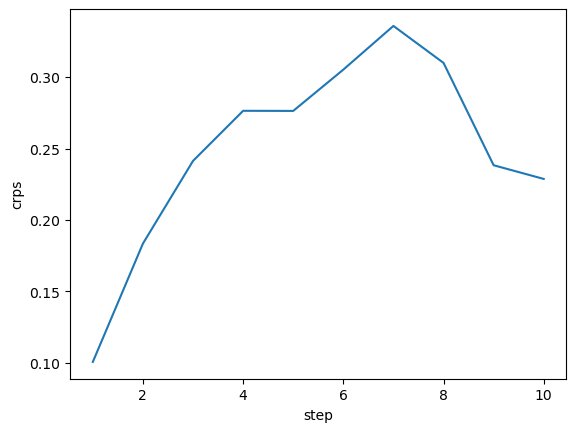

In [176]:
sns.lineplot(data=crps_df, x="step", y="crps")

In [32]:
def combine_crps(module, boxes=[88], start_date='2020-01-01', end_date='2021-12-31', ar_steps=10, max_dates=5, runs=10, sigma=0.001):
    d1 = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    d2 = d1 + datetime.timedelta(days=10)
    d = []
    i = 0
    while d2 < end_date and i < max_dates:
        results = predict(module, ar_steps=ar_steps, boxes=boxes, 
                                     slice_start=d1.strftime("%Y-%m-%d"), 
                                     slice_end=d2.strftime("%Y-%m-%d"),
                                     runs=runs,
                                     sigma=sigma
                         )
        crps_curr = crps(results, ar_steps=ar_steps, date=d1.strftime("%Y-%m-%d"))
#         print(crps_curr)
        d.extend(crps_curr)
        d1 = d2
        d2 = d1 + datetime.timedelta(days=10)
        i +=1
    return d   

In [178]:
%%time
full_crps_list = combine_crps(module)

100%|█████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.78s/it]

CPU times: user 29min 53s, sys: 21.8 s, total: 30min 15s
Wall time: 35min 27s


In [185]:
data = pd.DataFrame(full_crps_list)
data['wandb_id'] = wandb_id
data.to_csv()

In [39]:
data = pd.read_csv(f'data/crps/{wandb_id}.csv')

<AxesSubplot: xlabel='step', ylabel='crps'>

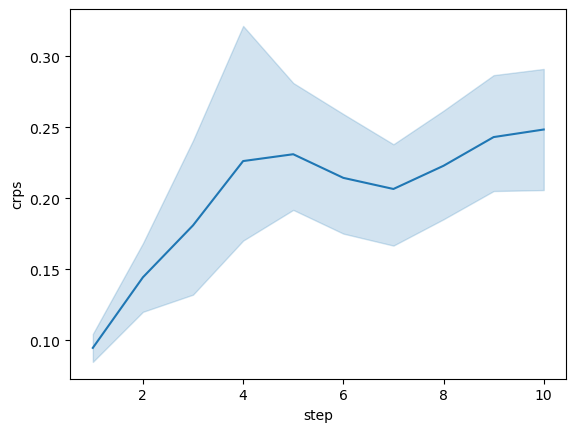

In [40]:
sns.lineplot(data, x="step", y="crps")

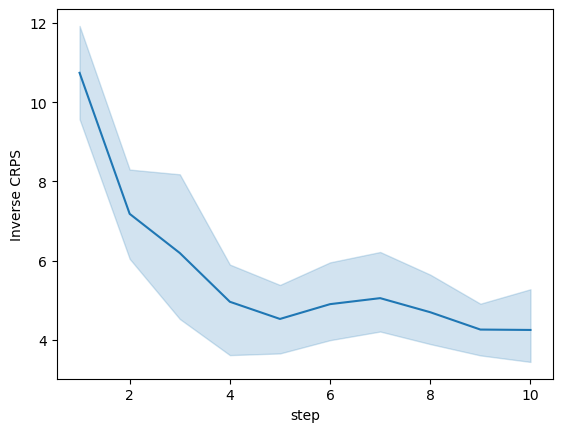

In [41]:
data['Inverse CRPS'] = 1/data['crps']
sns.lineplot(data=data, x="step", y="Inverse CRPS", )
plt.show()

In [35]:
MIXUP_WANDB_ID = '29jm1thk'

In [36]:
%%time
# OISSTv2-MixUp_Convex-ipol-500T_UNetResNet_64x3h_5e-05lr_11seed_15h44m_on_Nov_19_29jm1thk
module_mixup = reload_module(MIXUP_WANDB_ID, data_dir)

CPU times: user 4.78 s, sys: 1.24 s, total: 6.02 s
Wall time: 20.4 s


In [33]:
%%time
full_crps_list_mixup = combine_crps(module_mixup, max_dates=2, sigma=0.001, runs=10)

getting runs
i:  0


  0%|                                                             | 0/1 [37:20<?, ?it/s]


KeyboardInterrupt: 

In [37]:
data_mixup = pd.DataFrame(full_crps_list_mixup)
data_mixup['wandb_id'] = MIXUP_WANDB_ID
data_mixup.to_csv(f'data/crps/{MIXUP_WANDB_ID}.csv')

In [43]:
# data_mixup = data.copy()
# data_mixup['wandb_id'] = MIXUP_WANDB_ID

In [45]:
data_full = pd.concat([data,data_mixup])

In [48]:
data_full

,Unnamed: 0,step,crps,date,wandb_id,Inverse CRPS
0,0,1,0.103806,2020-01-01,3kkx899f,9.633317
1,1,2,0.189613,2020-01-01,3kkx899f,5.273895
2,2,3,0.290056,2020-01-01,3kkx899f,3.447607
3,3,4,0.412419,2020-01-01,3kkx899f,2.424719
4,4,5,0.312394,2020-01-01,3kkx899f,3.201083
...,...,...,...,...,...,...
45,45,6,0.296921,2020-02-10,29jm1thk,3.367901
46,46,7,0.254505,2020-02-10,29jm1thk,3.929194
47,47,8,0.231255,2020-02-10,29jm1thk,4.324234
48,48,9,0.259305,2020-02-10,29jm1thk,3.856459


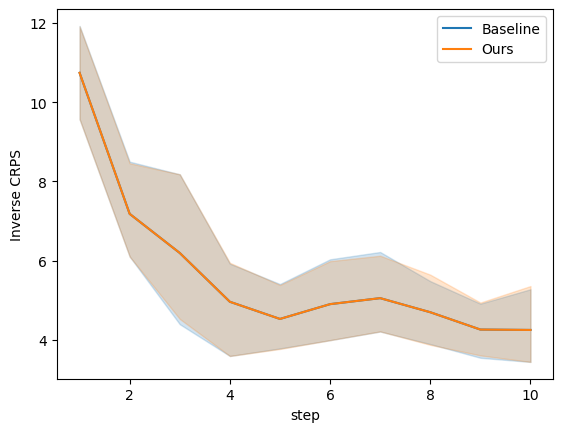

In [63]:
data_full['Inverse CRPS'] = 1/data_full['crps']
p = sns.lineplot(data=data_full, x="step", y="Inverse CRPS", hue='wandb_id')
legend = p.legend()
legend.texts[0].set_text("Baseline")
legend.texts[1].set_text("Ours")
plt.show()

In [21]:
def plot_results(results, ar_step=0):
    fig, ax = plt.subplots(4, 4, figsize=(10, 10))
    col = 0
    tsize=results['preds'].shape[0]
    for i in range(8):
        k =  tsize// (i+1) - 1
        p = results['preds'][k, 0, ...]
        y = results['targets'][k, 0, ...]

        ax[i%4, col].imshow(p)
        ax[i%4, col+1].imshow(y)
        if i % 4 == 3:
            col+=2
    for a in ax.flat:
        a.set_xticklabels([])
        a.set_yticklabels([])
        
def plot_ar(results, ar_steps=5, show_targets=True):
    k=3
    nrows = 2 if show_targets else 1
    fig, axs = plt.subplots(nrows, ar_steps, figsize=(ar_steps*k, nrows*k), sharey=True, sharex=True)
    for i in range(ar_steps):
        pred_key = 'preds' if i == 0  else f'preds_ar_{i}'
        p = results[pred_key][i, 0, ...]
        y = results['targets'][i, 0, ...]
        if show_targets:
            axs[0, i].imshow(p)
            axs[1, i].imshow(y)
        else:
            axs[i].imshow(p)


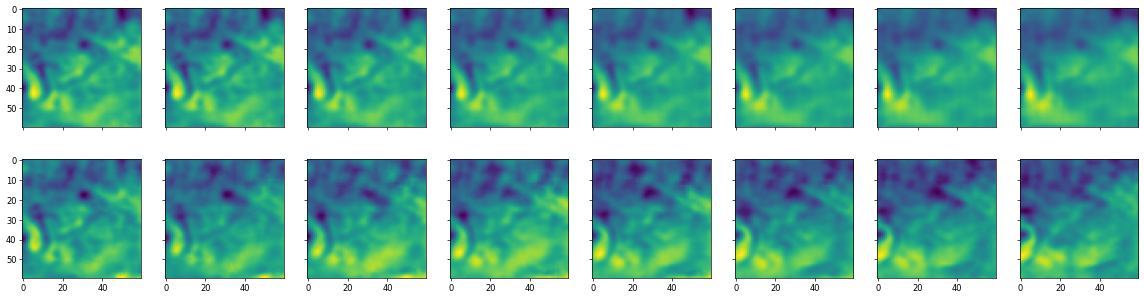

In [39]:
# plot_ar(results_mlp, ar_steps=8, show_targets=False)
plot_ar(results, ar_steps=8)